In [11]:
'''
I want to apply anomaly detection with LSTM to a real case.
I took last logs of our Agile Sprint total line of codes submitted by day.
A Sprint duration is 14 days.
Some Sprints are difficult some are easy.
So idea is finding at which periods we had bad performed.
Code is standard code samples at keras.
Here we do not label anomalies we find them when mean error
in train set and find mean error in test set.

Since values are scaled into unit distribution we can understand anomaly when
abs mean is 1.
if mean is -1 it means we made 1 z score worser than we did normally
if mean is +1 it means we made 1 z score better than we did normally
1z score is our normal performance and it's near vicinity with distribution %33

'''
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import StandardScaler


In [52]:
df = pd.read_csv('D:/data2/gitstats.csv', index_col='date')

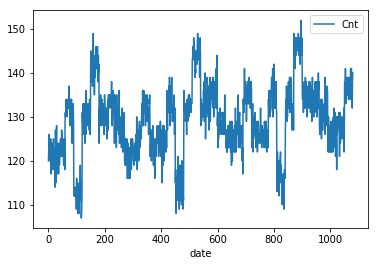

In [53]:
df.plot()

In [54]:
split_ratio = 0.75

In [55]:

train_size = int(len(df) * split_ratio)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(810, 1) (270, 1)


In [56]:
scaler = StandardScaler()
scaler = scaler.fit(train[['Cnt']])

train['Cnt'] = scaler.transform(train[['Cnt']])
test['Cnt'] = scaler.transform(test[['Cnt']])

C:\Users\mcelikkaya\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mcelikkaya\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\mcelikkaya\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\mcelikkaya\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """
C:\Users\

C:\Users\mcelikkaya\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


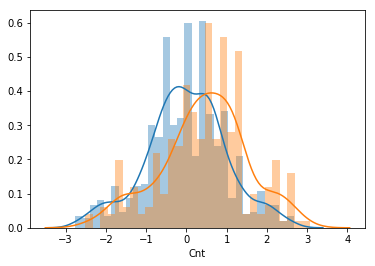

In [57]:
sns.distplot(train['Cnt'], bins=30)
sns.distplot(test['Cnt'], bins=30)
#Here we can see the distribution of test and train sets

In [23]:
def create_dataset(X, y, sprint_duration):
    Xs, ys = [], []
    for i in range(len(X) - sprint_duration):
        Xs.append(X.iloc[i:(i + sprint_duration)].values)        
        ys.append(y.iloc[i + sprint_duration])
    return np.array(Xs), np.array(ys)

In [24]:
sprint_duration = 14
X_train, y_train = create_dataset(train[['Cnt']], train.Cnt, sprint_duration)
X_test, y_test = create_dataset(test[['Cnt']], test.Cnt, sprint_duration)

print(X_train.shape)
print(y_train.shape)

(796, 14, 1)
(796,)


In [59]:
print("x",X_train[0])
print("y",y_train[0])
#here we make time steps of 14 to generate next 1

x [[-1.08238247]
 [-0.82341635]
 [-0.30548411]
 [-0.30548411]
 [-0.95289941]
 [-1.08238247]
 [-0.69393329]
 [-0.56445023]
 [-0.43496717]
 [-1.34134859]
 [-1.47083165]
 [-0.56445023]
 [-1.08238247]
 [-1.08238247]]
y -1.2118655262187397


In [60]:
model = keras.Sequential()
model.add(keras.layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [61]:
history = model.fit(X_train, y_train,epochs=20,batch_size=12,validation_split=0.1,shuffle=False)

Train on 716 samples, validate on 80 samples
Epoch 1/20
716/716 [==============================] - 4s 6ms/sample - loss: 0.5661 - val_loss: 0.3541
Epoch 2/20
716/716 [==============================] - 1s 1ms/sample - loss: 0.4711 - val_loss: 0.3449
Epoch 3/20
716/716 [==============================] - 1s 1ms/sample - loss: 0.4484 - val_loss: 0.3387
Epoch 4/20
716/716 [==============================] - 1s 1ms/sample - loss: 0.4438 - val_loss: 0.3381
Epoch 5/20
716/716 [==============================] - 1s 1ms/sample - loss: 0.4291 - val_loss: 0.3375
Epoch 6/20
716/716 [==============================] - 1s 1ms/sample - loss: 0.4315 - val_loss: 0.3364
Epoch 7/20
716/716 [==============================] - 1s 1ms/sample - loss: 0.4245 - val_loss: 0.3415
Epoch 8/20
716/716 [==============================] - 1s 1ms/sample - loss: 0.4397 - val_loss: 0.3414
Epoch 9/20
716/716 [==============================] - 1s 1ms/sample - loss: 0.4249 - val_loss: 0.3357
Epoch 10/20
716/716 [================

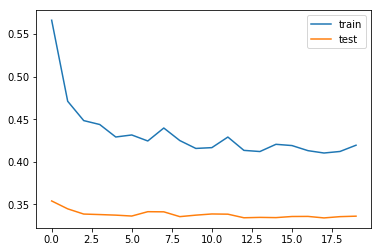

In [62]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [63]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [64]:
test_mae_loss.shape

(256, 1)

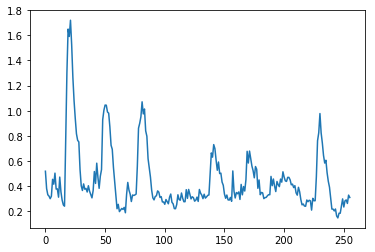

In [66]:
plt.plot(test_mae_loss)
plt.show()
#Hwre we can see most unexpected values near 1.6 

In [67]:
#This values could be anything, it will show how far values from 
#mean will be treated as anormal
THRESHOLD = 1.4

test_score_df = pd.DataFrame(index=test[sprint_duration:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['Cnt'] = test[sprint_duration:].Cnt

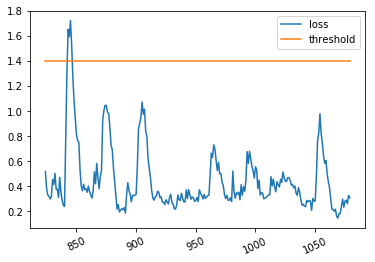

In [68]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [69]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,Cnt
date,,,,
843,1.650215,1.4,True,0.471414
844,1.591104,1.4,True,1.118830
845,1.720524,1.4,True,0.600897
846,1.523616,1.4,True,0.082965


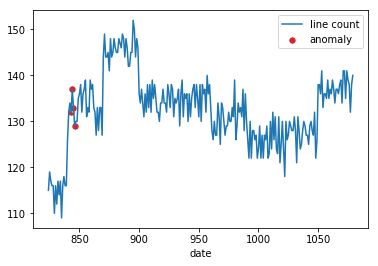

In [70]:
plt.plot(
  test[sprint_duration:].index, 
  scaler.inverse_transform(test[sprint_duration:].Cnt), 
  label='line count'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.Cnt),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
#plt.xticks(rotation=25)
plt.legend();